<a href="https://colab.research.google.com/github/Tung003/ANN_pytorch_cuda/blob/master/Artificial_neural_networks_only_MATH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install tqdm
!pip install scikit-learn

In [111]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

#split data to train and test and val
[10000 samples test, 10000 samples val and 50000 samples train]

In [ ]:
def processed_data():
      path_train="/content/drive/MyDrive/Colab Notebooks/MNIST/new_mnist/mnist_train.csv"
      path_test ="/content/drive/MyDrive/Colab Notebooks/MNIST/new_mnist/mnist_test.csv"
      path_val  ="/content/drive/MyDrive/Colab Notebooks/MNIST/new_mnist/mnist_val.csv"
      if not os.path.exists(path_train):
          raise FileNotFoundError("File not found please check ",path_train)
      if not os.path.exists(path_test):
          raise FileNotFoundError("File not found please check ",path_test)
      if not os.path.exists(path_val):
          raise FileNotFoundError("File not found please check ",path_val)

      df_train=pd.read_csv(path_train)
      df_test =pd.read_csv(path_test)
      df_val  =pd.read_csv(path_val)
      target="label"
      #chia bộ train và bộ test
      y_train= df_train[target]
      x_train= df_train.drop(target,axis=1)
      y_test= df_test[target]
      x_test= df_test.drop(target,axis=1)
      y_val = df_val[target]
      x_val =df_val.drop(target,axis=1)

      x_train, x_val, x_test= x_train/255., x_val/255., x_test/255.
      return x_train,x_test,x_val,y_train,y_test,y_val


#One hot label

In [113]:
def one_hot(labels,numclases=10):
      """
          0=>label=0000000000
          1=>label=0100000000
          4=>label=0000100000
          9=>label=0000000001
      """
      label_return=np.zeros(numclases)
      label_return[labels]=1
      return label_return

#Load data
input [mini batch from data]

In [114]:
class load_data:
  """
      train_data shape= (50000, 784)
      put to model 100 samples each time [batch_size=100]
  """
  def __init__(self,data,label,shufle=True):
        self.data = np.array(data)
        self.label = np.array(label)

        if shufle:
          indices = np.arange(len(self.data))
          np.random.shuffle(indices)
          self.data = self.data[indices]
          self.label = self.label[indices]

  def __getitem__(self,index):
        return self.data[index],one_hot(self.label[index])

  def __len__(self):
        return len(self.data)

  def get_batch(self,batch_size):
        """
            input: num of batch size
            output: batch size samples x and y (one-hot)
        """
        indices = np.random.choice(len(self.data), batch_size, replace=False)
        batch_X = self.data[indices]
        batch_y = np.array([one_hot(self.label[i]) for i in indices])

        return batch_X, batch_y


# Parent Class

In [115]:
class Layer:
  """
      Parent class: attribute [input, output]
                           method  [forward, backward]
  """
  def __init__(self,input,output):
        self.input=None
        self.output=None

  def forward(self,input):
        pass

  def backward(self,output_gradien,learning_rate):
        pass

#Class Activation


In [116]:
#Activtion class
class Activation(Layer):
    def __init__(self,activation,activation_prime):
        self.activation=activation
        self.activation_prime=activation_prime

    def forward(self,input):
        self.input=input
        return self.activation(self.input)

    def backward(self,output_gradient,lr):
        return np.multiply(self.activation_prime(self.input),output_gradient)

class Tanh(Activation):
    def __init__(self):
        super().__init__(self.tanh,self.tanh_prime)
    def tanh(self,x):
        return np.tanh(x)
    def tanh_prime(self,x):
        return 1-np.tanh(x)**2

class Relu(Activation):
    def __init__(self):
        super().__init__(self.relu,self.relu_prime)

    def relu(self,x):
        return np.maximum(0,x)
    def relu_prime(self,x):
        return (x>0).astype(x.dtype)

class Leaky_Relu(Activation):
    def __init__(self,alpha=0.01):
        super().__init__(self.leaky_relu,self.leaky_relu_prime)

    def leaky_relu(self,x):
        return np.where(x>0,x, self.alpha*x)
    def leaky_relu_prime(self,x):
        return np.where(x>0, 1,self.alpha)

class Softmax(Layer):
    def __init__(self, input=None, output=None):
        super().__init__(None,None)
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
        self.output = exp_x / (np.sum(exp_x, axis=-1, keepdims=True)+1e-15)
        return self.output

    def backward(self, output_gradient, lr):
        # Output gradient phải đến từ cross-entropy, đã tính gộp
        return output_gradient

#Class ANN

In [117]:
class Artificial_Neuron_Networks_new(Layer):
    """
        input[2x3]=input[1x6]=>Z=X.W+B -> W[6 x output_size]
        vì 2 ma trận X và W nhân với nhau cho ra ma trận s'=[1x6].[6 x output_size]
        s'=[1 x output_size]
        và B phải có kích thước [1 x output_size] để cộng s' với B => Z=[1 x output_size]
        *{Z0=x0.W00 + x1.W10 + x2.W20 + x3.W30 + x4.W40 + x5.W50 + b0}
        {Z1=x0.W01 + x1.W11 + x2.W21 + x3.W31 + x4.W41 + x5.W51 + b1}
        {Z2=x0.W02 + x1.W12 + x2.W22 + x3.W32 + x4.W42 + x5.W52 + b2}
        {Z3=x0.W03 + x1.W13 + x2.W23 + x3.W33 + x4.W43 + x5.W53 + b3}
        {Z4=x0.W04 + x1.W14 + x2.W24 + x3.W34 + x4.W44 + x5.W54 + b4}
        {Z5=x0.W05 + x1.W15 + x2.W25 + x3.W35 + x4.W45 + x5.W55 + b5}
        {Z6=x0.W06 + x1.W16 + x2.W26 + x3.W36 + x4.W46 + x5.W56 + b6}
    """
    def __init__(self,num_in_neuron,num_out_neuron,activation=None):
        #super().__init__(num_in_neuron, num_out_neuron)
        self.weight = np.random.randn(num_in_neuron, num_out_neuron)* np.sqrt(2. / num_in_neuron)
        self.bias=np.zeros((1,num_out_neuron))
        self.activation=activation

    def forward(self,input):
        """
            nếu input có 6 neural đầu vào và ta đặt số neural đầu ra là 7
            w có kích thước là 6 hàng 7 cột
            b có kích thước là 1 hàng 7 cột
        """
        self.input=input
        return np.dot(self.input,self.weight)+self.bias #Z=X.W+B


    def backward(self,output_gradient,lr):
        """
            ta cần tính được đạo hàm của hàm lỗi E với W, X, B và với Z
            tính đạo hàm riêng dE/dW: giả sử ta dùng hàm loss E là MSE = 1/2(Z-Z')^2
            + tính đạo hàm dE/dW00 theo quy tắc chuỗi nối tiếp thì
            dE/dW00= (dE/dZ0).(dZ0/dW00) + (dE/dZ1).(dZ1/dW00) +...+ (dE/dZ6).(dZ6/dW00)
            dE/dW13= (dE/dZ0).(dZ0/dW13) + (dE/dZ1).(dZ1/dW13) +..+ (dE/dZ3).(dZ3/dW13) + ...
            ở đây có thể thấy được rằng từ (*) ở trên
            thì dE/dW00 chỉ có (dE/dZ0).dZ0/dW00 {dZ0/dW00 = x0 còn các giá trị dZ1/dW00...đều bằng 0}
            => dE/dW00 = (dE/dZ0). x0 ; dE/dW13 = (dE/dZ3).x1
            theo quỹ tắc đạo hàm theo chuỗi thì ta cũng có thể đổi vị trí hay phép tính
            dE/dW13 = (dE/dZ3).x1 hoặc x1.(dE/dZ3)
            từ đây rút ra công thức tổng quát: dE/dW(i,j)=xi.(dE/dZj)
            và rút ra công thức theo ma trận: Xt.(dE/dZ) (**)
        """
        w_grad=np.dot(self.input.T,output_gradient)
        bias_grad = np.mean(output_gradient, axis=0, keepdims=True)
        self.weight-=lr*w_grad
        self.bias-=lr* bias_grad
        return np.dot(output_gradient,self.weight.T)

#Networks Architech

In [118]:
networks=[Artificial_Neuron_Networks_new(784,512),
                  Relu(),
                  Artificial_Neuron_Networks_new(512,256),
                  Relu(),
                  Artificial_Neuron_Networks_new(256,128),
                  Relu(),
                  Artificial_Neuron_Networks_new(128,64),
                  Relu(),
                  Artificial_Neuron_Networks_new(64,32),
                  Relu(),
                  Artificial_Neuron_Networks_new(32,10),
                  Softmax()]

#Predict func and Loss func


In [119]:
#Predict function
def pred(networks,input):
      output=input
      for layer in networks:
          output=layer.forward(output)
      return output
#loss function forrward
def softmax_cross_entropy_loss(y_true, y_pred):
      """
          y_true: (batch_size,) — nhãn đúng
          logits: (batch_size, num_classes) — output thô từ mạng (chưa softmax)
      """
      # softmax
      eps = 1e-15
      y_pred = np.clip(y_pred, eps, 1 - eps)
      loss = -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]
      return loss
#loss function backward
def softmax_cross_entropy_loss_backward(y_true, y_pred):
      """
          Gradient của softmax + cross-entropy
          probs: output sau softmax
          y_true: vector nhãn (batch_size,)
      """
      return (y_pred - y_true) / y_true.shape[0]

#Accuracy func

In [120]:
#Accuracy function
def accuracy(y_predict, y_true):
    """
        Accuracy.
        y_predict: (batch_size, num_classes)
        y_true: (batch_size, num_classes) (one-hot encoded)
    """
    predict_labels = np.argmax(y_predict, axis=1)
    true_labels = np.argmax(y_true, axis=1)
    return np.mean(predict_labels == true_labels)

#Training model

In [121]:
#training
def train(networks, data_loader, epochs=10, batch_size=32, learning_rate=0.01):
    """
        Huấn luyện mạng neural network.
        networks: 1 mảng các lớp kết nối đầy đủ.
        data_loader: dữ liệu huấn luyện.
        epochs: số vòng lặp huấn luyện(số lần toàn bộ dữ liệu được huấn luyện cho mô hình).
        batch_size: số lượng mẫu mỗi batch.
        learning_rate: tốc độ học.
    """
    for epoch in tqdm(range(epochs)):
        #Train params
        train_loss = 0
        train_acc = 0
        num_batches = len(data_loader) // batch_size
        # Validation params
        val_loss=0
        val_acc=0

        ################## Training loop ###################
        for _ in range(num_batches):
            # get batch data train x and y
            batch_X, batch_y = data_loader.get_batch(batch_size)

            # forward
            output = batch_X
            for layer in networks:
                output = layer.forward(output)
            # compute loss
            loss = softmax_cross_entropy_loss(batch_y, output)
            train_loss += loss

            # compute accuracy
            acc = accuracy(output, batch_y)
            train_acc += acc

            # backward
            grad = softmax_cross_entropy_loss_backward(batch_y, output)
            for layer in reversed(networks):
                grad = layer.backward(grad, learning_rate)
        ################## end 1 epoch ###################


        ################## Validation loop ##################
        for _ in range(num_batches):
            x_val_test,y_val_test = val_loader.get_batch(batch_size)

            output_val=x_val_test
            for layer in networks:
                output_val = layer.forward(output_val)

            loss_val = softmax_cross_entropy_loss(y_val_test, output_val)
            val_loss += loss_val
            acc_v=accuracy(output_val,y_val_test)
            val_acc+=acc_v
        ################## end 1 time validation ##############
        # avegare loss and accuracy train in epoch
        avg_loss_train = train_loss / num_batches
        avg_acc_train = train_acc / num_batches
        # avegare loss and accuracy validation in epoch
        avg_loss_val = val_loss / num_batches
        avg_acc_val = val_acc / num_batches
        print(f"                    Epoch {epoch+1}/{epochs} - Loss: {avg_loss_train:.4f} - Accuracy: {avg_acc_train:.4f}           Val_loss: {avg_loss_val:.4f} - Accuracy: {avg_acc_val:.4f}")


#Main training model

In [122]:
if __name__=="__main__":

    x_train,x_test,x_val,y_train,y_test,y_val=processed_data()
    # load data train và test
    train_loader  = load_data(x_train , y_train)
    test_loader   = load_data(x_test  , y_test)
    val_loader    =load_data (x_val    ,y_val)
    # Huấn luyện mô hình
    train(networks, train_loader, epochs=30, batch_size=64, learning_rate=0.001)

  3%|▎         | 1/30 [00:24<11:57, 24.74s/it]

                    Epoch 1/30 - Loss: 2.1459 - Accuracy: 0.2505           Val_loss: 1.9330 - Accuracy: 0.3707


  7%|▋         | 2/30 [00:47<10:56, 23.46s/it]

                    Epoch 2/30 - Loss: 1.6684 - Accuracy: 0.4770           Val_loss: 1.3952 - Accuracy: 0.5697


 10%|█         | 3/30 [01:11<10:43, 23.84s/it]

                    Epoch 3/30 - Loss: 1.1253 - Accuracy: 0.6959           Val_loss: 0.8723 - Accuracy: 0.7797


 13%|█▎        | 4/30 [01:32<09:45, 22.52s/it]

                    Epoch 4/30 - Loss: 0.7246 - Accuracy: 0.8160           Val_loss: 0.6308 - Accuracy: 0.8294


 17%|█▋        | 5/30 [01:55<09:35, 23.01s/it]

                    Epoch 5/30 - Loss: 0.5565 - Accuracy: 0.8513           Val_loss: 0.5142 - Accuracy: 0.8590


 20%|██        | 6/30 [02:15<08:47, 21.96s/it]

                    Epoch 6/30 - Loss: 0.4700 - Accuracy: 0.8716           Val_loss: 0.4515 - Accuracy: 0.8751


 23%|██▎       | 7/30 [02:39<08:38, 22.52s/it]

                    Epoch 7/30 - Loss: 0.4170 - Accuracy: 0.8857           Val_loss: 0.4006 - Accuracy: 0.8909


 27%|██▋       | 8/30 [02:59<08:00, 21.84s/it]

                    Epoch 8/30 - Loss: 0.3793 - Accuracy: 0.8969           Val_loss: 0.3691 - Accuracy: 0.8985


 30%|███       | 9/30 [03:24<07:59, 22.83s/it]

                    Epoch 9/30 - Loss: 0.3486 - Accuracy: 0.9038           Val_loss: 0.3479 - Accuracy: 0.9009


 33%|███▎      | 10/30 [03:45<07:19, 22.00s/it]

                    Epoch 10/30 - Loss: 0.3233 - Accuracy: 0.9113           Val_loss: 0.3247 - Accuracy: 0.9071


 37%|███▋      | 11/30 [04:05<06:47, 21.46s/it]

                    Epoch 11/30 - Loss: 0.3073 - Accuracy: 0.9150           Val_loss: 0.3091 - Accuracy: 0.9129


 40%|████      | 12/30 [04:29<06:39, 22.21s/it]

                    Epoch 12/30 - Loss: 0.2958 - Accuracy: 0.9174           Val_loss: 0.2946 - Accuracy: 0.9146


 43%|████▎     | 13/30 [04:49<06:06, 21.57s/it]

                    Epoch 13/30 - Loss: 0.2823 - Accuracy: 0.9212           Val_loss: 0.2818 - Accuracy: 0.9171


 47%|████▋     | 14/30 [05:14<06:03, 22.69s/it]

                    Epoch 14/30 - Loss: 0.2635 - Accuracy: 0.9258           Val_loss: 0.2764 - Accuracy: 0.9183


 50%|█████     | 15/30 [05:35<05:30, 22.04s/it]

                    Epoch 15/30 - Loss: 0.2589 - Accuracy: 0.9273           Val_loss: 0.2711 - Accuracy: 0.9208


 53%|█████▎    | 16/30 [06:00<05:21, 22.98s/it]

                    Epoch 16/30 - Loss: 0.2444 - Accuracy: 0.9308           Val_loss: 0.2489 - Accuracy: 0.9287


 57%|█████▋    | 17/30 [06:20<04:47, 22.11s/it]

                    Epoch 17/30 - Loss: 0.2379 - Accuracy: 0.9316           Val_loss: 0.2462 - Accuracy: 0.9279


 60%|██████    | 18/30 [06:43<04:29, 22.50s/it]

                    Epoch 18/30 - Loss: 0.2285 - Accuracy: 0.9364           Val_loss: 0.2341 - Accuracy: 0.9319


 63%|██████▎   | 19/30 [07:04<04:00, 21.87s/it]

                    Epoch 19/30 - Loss: 0.2218 - Accuracy: 0.9355           Val_loss: 0.2285 - Accuracy: 0.9323


 67%|██████▋   | 20/30 [07:24<03:33, 21.36s/it]

                    Epoch 20/30 - Loss: 0.2149 - Accuracy: 0.9394           Val_loss: 0.2224 - Accuracy: 0.9344


 70%|███████   | 21/30 [07:48<03:19, 22.12s/it]

                    Epoch 21/30 - Loss: 0.2100 - Accuracy: 0.9391           Val_loss: 0.2175 - Accuracy: 0.9364


 73%|███████▎  | 22/30 [08:08<02:51, 21.47s/it]

                    Epoch 22/30 - Loss: 0.1974 - Accuracy: 0.9439           Val_loss: 0.2141 - Accuracy: 0.9372


 77%|███████▋  | 23/30 [08:32<02:35, 22.18s/it]

                    Epoch 23/30 - Loss: 0.1984 - Accuracy: 0.9440           Val_loss: 0.2099 - Accuracy: 0.9400


 80%|████████  | 24/30 [08:51<02:08, 21.49s/it]

                    Epoch 24/30 - Loss: 0.1887 - Accuracy: 0.9467           Val_loss: 0.2021 - Accuracy: 0.9396


 83%|████████▎ | 25/30 [09:14<01:48, 21.75s/it]

                    Epoch 25/30 - Loss: 0.1839 - Accuracy: 0.9472           Val_loss: 0.1951 - Accuracy: 0.9415


 87%|████████▋ | 26/30 [09:35<01:26, 21.71s/it]

                    Epoch 26/30 - Loss: 0.1817 - Accuracy: 0.9488           Val_loss: 0.1924 - Accuracy: 0.9436


 90%|█████████ | 27/30 [10:00<01:07, 22.55s/it]

                    Epoch 27/30 - Loss: 0.1784 - Accuracy: 0.9485           Val_loss: 0.1943 - Accuracy: 0.9428


 93%|█████████▎| 28/30 [10:23<00:45, 22.56s/it]

                    Epoch 28/30 - Loss: 0.1697 - Accuracy: 0.9525           Val_loss: 0.1826 - Accuracy: 0.9435


 97%|█████████▋| 29/30 [10:42<00:21, 21.75s/it]

                    Epoch 29/30 - Loss: 0.1651 - Accuracy: 0.9534           Val_loss: 0.1887 - Accuracy: 0.9446


100%|██████████| 30/30 [11:06<00:00, 22.22s/it]

                    Epoch 30/30 - Loss: 0.1637 - Accuracy: 0.9532           Val_loss: 0.1841 - Accuracy: 0.9445


#Predict x test

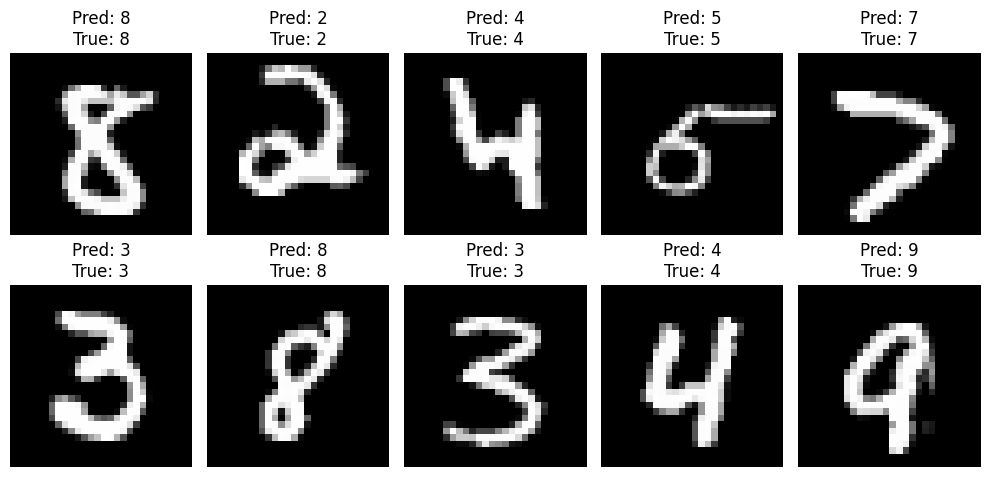

In [128]:
def visualize_predictions(networks, data_loader, num_samples=10):
    """
        Show 10 images from test data set and labels.
    """
    batch_x, batch_y = data_loader.get_batch(num_samples)  # get 10 imgaes from test data set

    output = batch_x
    for layer in networks:
        output = layer.forward(output)

    predictions = np.argmax(output, axis=1)
    true_labels = np.argmax(batch_y, axis=1)

    fig, axes = plt.subplots(2, 5, figsize=(10, 5))
    axes = axes.ravel()

    for i in range(num_samples):
        axes[i].imshow(batch_x[i].reshape(28, 28), cmap='gray')
        axes[i].set_title(f"Pred: {predictions[i]}\nTrue: {true_labels[i]}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

visualize_predictions(networks, test_loader, num_samples=10)


#Save model

In [131]:
# save weight model
def save_weights(networks, filename="model_weights1.npz"):
    weights = {}
    biases = {}

    for i, layer in enumerate(networks):
        if hasattr(layer, "weight") and hasattr(layer, "bias"):
            weights[f"W_{i}"] = layer.weight
            biases[f"b_{i}"] = layer.bias

    np.savez(filename, **weights, **biases)
    print(f"Weight save to {filename}")

save_weights(networks)


Weight save to model_weights1.npz


#Load model

In [132]:
def load_weights(networks, filename="model_weights.npz"):
    data = np.load(filename)
    for i, layer in enumerate(networks):
        if hasattr(layer, "weight") and hasattr(layer, "bias"):
            layer.weight = data[f"W_{i}"]
            layer.bias = data[f"b_{i}"]
    print(f"Weight load from {filename}")

load_weights(networks)


Weight load from model_weights.npz


#Test

In [133]:
def test_model(networks, data_loader, num_samples=100):
    batch_X, batch_y = data_loader.get_batch(num_samples)  # get 10 image test

    output = batch_X
    for layer in networks:
        output = layer.forward(output)

    predictions = np.argmax(output, axis=1)
    true_labels = np.argmax(batch_y, axis=1)
    acc=np.mean(predictions==true_labels)
    print("Predict  |  Label")
    print("-" * 20)
    for pred, true in zip(predictions[0:5], true_labels[0:5]):
        print(f"   {pred}       |     {true}")
    print(acc)
load_weights(networks, "model_weights.npz")

test_model(networks, test_loader, num_samples=10000)


Weight load from model_weights.npz
Predict  |  Label
--------------------
   3       |     3
   8       |     8
   1       |     1
   3       |     3
   6       |     6
0.9497
